I ran this query via the Datathon intro colab page then have used a CSV to load into a Pandas DataFrame

In [2]:
ventAnalysis = client.query('''
    SELECT
      person_id,
      visit_occurrence_id,
      measurement_concept_id,
      measurement_datetime,
      measurement_type_concept_id,
      value_as_number,
      unit_concept_id,
      provider_id
    FROM measurement
    WHERE
      NOT provider_id IS NULL -- ignore unvalidated device data
      AND measurement_concept_id IN (
        3020716, --fio2
        42527120, --eMV
        42527121, --iMV
        21490855, --PEEP
        21490582, --Cdyn
        21490583, --Cstat
        42527086, --mean airway pressure
        44782825, --Pplat
        3035357, --ETCO2
        3013290, --pCO2
        3027315 --pO2

    )
    ''',
                            job_config=job_config).to_dataframe()

NameError: name 'client' is not defined

In [4]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv('/Users/matthewwillis/Local Dev/ESICM_datathon/out.csv')

In [6]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [7]:
# bin results into 20 bins
pd.cut(df['value_as_number'], 20).value_counts().sort_index()

value_as_number
(-1.005, 50.25]     5107128
(50.25, 100.5]         5904
(100.5, 150.75]        1994
(150.75, 201.0]         490
(201.0, 251.25]          12
(251.25, 301.5]           4
(301.5, 351.75]          12
(351.75, 402.0]          26
(402.0, 452.25]          38
(452.25, 502.5]          70
(502.5, 552.75]          52
(552.75, 603.0]          18
(603.0, 653.25]          14
(653.25, 703.5]           4
(703.5, 753.75]           6
(753.75, 804.0]           0
(804.0, 854.25]           0
(854.25, 904.5]           0
(904.5, 954.75]           0
(954.75, 1005.0]          2
Name: count, dtype: int64

In [8]:
# remove outliers (MV < 100 and MV > 0)

df = df[df['value_as_number'] < 100]
df = df[df['value_as_number'] > 0]

df.reset_index(drop=True, inplace=True)
df

,person_id,visit_occurrence_id,measurement_concept_id,measurement_datetime,measurement_type_concept_id,value_as_number,unit_concept_id,provider_id
0,18392,21299,42527120,2006-01-01 03:45:00+00:00,32817,1.0,8698,40
1,18979,21980,42527120,2013-01-07 18:30:00+00:00,32817,1.0,8698,40
2,16354,18964,42527120,2006-01-01 00:11:00+00:00,32817,2.0,8698,40
3,19498,22568,42527120,2006-01-24 15:39:00+00:00,32817,2.0,8698,40
4,15547,18007,42527120,2006-01-01 04:29:00+00:00,32817,2.0,8698,40
...,...,...,...,...,...,...,...,...
5106687,6229,7215,42527120,2013-01-10 21:39:00+00:00,32817,0.9,8698,40
5106688,5803,6719,42527120,2015-08-08 01:42:00+00:00,32817,0.9,8698,40
5106689,6096,7060,42527120,2006-01-09 22:22:00+00:00,32817,0.9,8698,40
5106690,3030,3488,42527120,2006-01-19 19:17:00+00:00,32817,0.9,8698,40


In [9]:
# group by person and occurrence
df_grouped = df.groupby(['person_id', 'visit_occurrence_id']).agg({'measurement_datetime': ['max', 'min'], 'value_as_number': ['count', 'mean', 'std']})

In [10]:
df_grouped.columns

MultiIndex([('measurement_datetime',   'max'),
            ('measurement_datetime',   'min'),
            (     'value_as_number', 'count'),
            (     'value_as_number',  'mean'),
            (     'value_as_number',   'std')],
           )

In [11]:
# calculate the difference between the max and min dates (for Minute Ventilation) - rough idea of duration of mechanical ventilation

df_grouped[('measurement_datetime','max')] = pd.to_datetime(df_grouped[('measurement_datetime','max')])
df_grouped[('measurement_datetime','min')] = pd.to_datetime(df_grouped[('measurement_datetime','min')])

df_grouped['diff'] = (df_grouped[('measurement_datetime','max')] - df_grouped[('measurement_datetime','min')]).dt.days
df_grouped[df_grouped['diff'] >= 4]

measurement_datetime  \
                                                    max   
person_id visit_occurrence_id                             
14        15                  2013-01-10 18:38:00+00:00   
20        21                  2006-01-06 20:49:00+00:00   
31        32                  2013-01-08 17:51:00+00:00   
33        35                  2013-01-06 09:00:00+00:00   
36        38                  2013-01-30 23:25:00+00:00   
...                                                 ...   
20271     23488               2013-01-06 08:31:00+00:00   
20284     23503               2013-01-06 06:43:00+00:00   
20289     23509               2013-07-26 17:58:00+00:00   
20290     23510               2013-01-05 04:40:00+00:00   
20293     23516               2018-01-05 18:29:00+00:00   

                                                        value_as_number  \
                                                    min           count   
person_id visit_occurrence_id                                             
14        15                  2013-01-01 01:38:00+00:00             840   
20        21                  2006-01-01 03:07:00+00:00             564   
31        32                  2013-01-01 00:06:00+00:00             728   
33        35                  2013-01-01 00:29:00+00:00             452   
36        38                  2013-01-01 00:03:00+00:00            2540   
...                                                 ...             ...   
20271     23488               2013-01-01 00:31:00+00:00             484   
20284     23503               2013-01-01 00:43:00+00:00             492   
20289     23509               2013-07-16 12:43:00+00:00             960   
20290     23510               2013-01-01 04:15:00+00:00             350   
20293     23516               2017-12-19 17:55:00+00:00             828   

                                                   diff  
                                    mean       std       
person_id visit_occurrence_id                            
14        15                    9.684524  2.237618    9  
20        21                    6.749645  2.128004    5  
31        32                    7.312088  4.281937    7  
33        35                    7.258850  1.237205    5  
36        38                    8.097795  3.681198   29  
...                                  ...       ...  ...  
20271     23488                10.357438  4.802704    5  
20284     23503                 9.873577  2.445161    5  
20289     23509                11.253333  3.570226   10  
20290     23510                11.621714  7.359612    4  
20293     23516                17.751208  4.137122   17  

[3488 rows x 6 columns]

In [12]:
# as expected data skewed toward shorter stays
pd.cut(df_grouped['diff'], 20).value_counts().sort_index()

diff
(-0.237, 11.85]    13973
(11.85, 23.7]        971
(23.7, 35.55]        334
(35.55, 47.4]        139
(47.4, 59.25]         75
(59.25, 71.1]         30
(71.1, 82.95]         11
(82.95, 94.8]          4
(94.8, 106.65]         3
(106.65, 118.5]        0
(118.5, 130.35]        1
(130.35, 142.2]        0
(142.2, 154.05]        0
(154.05, 165.9]        0
(165.9, 177.75]        0
(177.75, 189.6]        2
(189.6, 201.45]        0
(201.45, 213.3]        1
(213.3, 225.15]        0
(225.15, 237.0]        1
Name: count, dtype: int64

In [13]:
df_grouped[df_grouped['diff'] >= 4]['diff'].describe()

count    3488.000000
mean       15.034690
std        14.587049
min         4.000000
25%         6.000000
50%        10.000000
75%        19.000000
max       237.000000
Name: diff, dtype: float64

In [14]:
df_vac = pd.read_csv('/Users/matthewwillis/Local Dev/ESICM_datathon/vented_totals.csv')

df_vac.columns

Index(['Unnamed: 0', 'visit_occurrence_id', 'measurement_concept_id',
       'measurement_datetime', 'measurement_type_concept_id',
       'value_as_number', 'unit_concept_id', 'provider_id'],
      dtype='object')

In [15]:
concept_ids = {
         "fio2":3020716,
        "eMV":42527120,
        "iMV":42527121,
        "PEEP":21490855,
        "Cdyn":21490582,
        "Cstat":21490583,
        "mean airway pressure":42527086,
        "Pplat":44782825,
        "ETCO2":3035357,
        "pCO2":3013290,
        "pO2":3027315
}

concept_ids['fio2']

3020716

In [16]:
for_series = []

for i in range(0, len(df_grouped[df_grouped['diff'] >= 4])):
    for_series.append(df_grouped[df_grouped['diff'] >= 4].index[i][1])


df_vented_pts = pd.Series(for_series, index=for_series)

df_vented_pts

15          15
21          21
32          32
35          35
38          38
         ...  
23488    23488
23503    23503
23509    23509
23510    23510
23516    23516
Length: 3488, dtype: int64

In [17]:
df_fio2 = df_vac[df_vac['measurement_concept_id'] == concept_ids['fio2']].drop(['Unnamed: 0', 'unit_concept_id', 'provider_id','measurement_concept_id', 'measurement_type_concept_id'], axis=1).sort_values(['visit_occurrence_id', 'measurement_datetime'])

In [18]:
df_fio2

,visit_occurrence_id,measurement_datetime,value_as_number
331136,12,2006-01-01 00:15:00+00:00,22.0
443412,12,2006-01-01 01:15:00+00:00,49.0
353504,12,2006-01-01 02:15:00+00:00,40.0
352331,12,2006-01-01 03:15:00+00:00,39.0
397671,12,2006-01-01 04:15:00+00:00,39.0
...,...,...,...
395121,23506,2006-01-01 04:25:00+00:00,40.0
395727,23506,2006-01-01 05:25:00+00:00,40.0
354088,23506,2006-01-01 05:40:00+00:00,40.0
399349,23506,2006-01-01 06:25:00+00:00,40.0


In [38]:
df_fio2['measurement_datetime'] = pd.to_datetime(df_fio2['measurement_datetime'])

df_fio2_grouped = df_fio2.groupby(['visit_occurrence_id', pd.Grouper(key='measurement_datetime', freq='h')]).agg({'value_as_number': ['max', 'min', 'mean', 'std', 'var', 'median', 'count']})

In [35]:
list_uniques = []

for i in range(0, len(df_fio2_grouped)):
    list_uniques.append(df_fio2_grouped.index[i][0])

new_series = pd.Series(list_uniques)

len(new_series.unique())

907

<Axes: xlabel='measurement_datetime'>

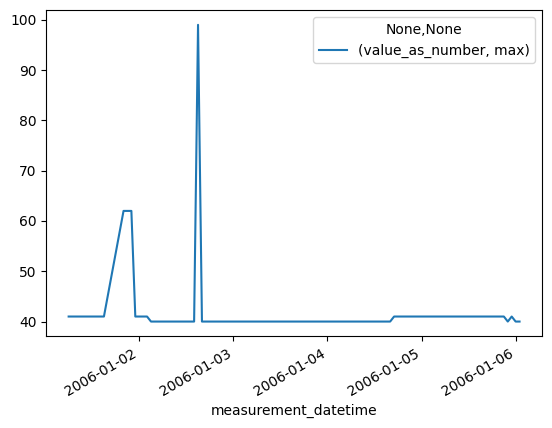

In [55]:
df_fio2_grouped['fio2_diff'] = df_fio2_grouped[('value_as_number','max')] - df_fio2_grouped[('value_as_number','min')]
df_ungroup = df_fio2_grouped.reset_index(inplace=False)

#df_ungroup[df_ungroup['visit_occurrence_id'] == 4788].plot(x='measurement_datetime', y=('value_as_number','median'))

df_ungroup[df_ungroup['visit_occurrence_id'] == 8852].plot(
    x='measurement_datetime', y=('value_as_number', 'max'))

# for x in df_ungroup['visit_occurrence_id'].unique()[0:5]:
#     df_ungroup[df_ungroup['visit_occurrence_id'] == x].plot(x='measurement_datetime', y=('value_as_number','median'))

In [46]:
df_ungroup['visit_occurrence_id'].value_counts()[50:150]

visit_occurrence_id
19615    415
16284    409
14206    409
19625    394
13681    382
        ... 
15610    109
8852     105
8384     105
14382    104
10437    104
Name: count, Length: 100, dtype: int64

/var/folders/7b/gs_txxb97cq5y3tfm8zty_1h0000gn/T/ipykernel_41126/3273847605.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ab_test['pct_change'] = ab_test['value_as_number']['max'].pct_change()


<Axes: xlabel='measurement_datetime'>

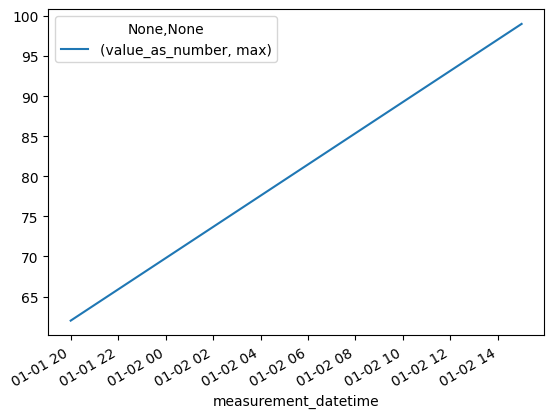

In [54]:
ab_test = df_ungroup[df_ungroup['visit_occurrence_id'] == 8852]

ab_test['pct_change'] = ab_test['value_as_number']['max'].pct_change()

ab_test[ab_test['pct_change'] > 0.2].plot(x='measurement_datetime', y=('value_as_number', 'max'))

In [22]:
grouped = df_ungroup.groupby('visit_occurrence_id')

# Step 3: Calculate the percentage change in fio2_diff over 2 consecutive days
df_ungroup['fio2_diff_change'] = grouped['fio2_diff'].pct_change()

# Step 4: Filter the dataframe
df_filtered = df_ungroup[df_ungroup['fio2_diff_change'] > 0.5]

df_filtered


visit_occurrence_id      measurement_datetime value_as_number        \
                                                               max   min   
3                     12 2006-01-04 00:00:00+00:00            73.0  40.0   
5                     12 2006-01-06 00:00:00+00:00            41.0  40.0   
17                   291 2006-01-03 00:00:00+00:00            99.0  40.0   
20                   291 2006-01-06 00:00:00+00:00            99.0  39.0   
22                   291 2006-01-08 00:00:00+00:00            98.0  39.0   
...                  ...                       ...             ...   ...   
4074               22780 2006-01-04 00:00:00+00:00            99.0  31.0   
4078               22780 2006-01-08 00:00:00+00:00            99.0  41.0   
4082               22787 2006-01-03 00:00:00+00:00            99.0  41.0   
4110               23474 2006-01-03 00:00:00+00:00            99.0  34.0   
4112               23474 2006-01-05 00:00:00+00:00            99.0  31.0   

                                              fio2_diff fio2_diff_change  
           mean        std         var median                             
3     41.458333   6.724253   45.215580   40.0      33.0        32.000000  
5     40.130435   0.344350    0.118577   40.0       1.0              inf  
17    44.928571  15.568530  242.379121   41.0      59.0         5.555556  
20    44.200000  13.442274  180.694737   40.0      60.0         4.000000  
22    42.157895  13.524723  182.918129   39.0      59.0        58.000000  
...         ...        ...         ...    ...       ...              ...  
4074  41.863636  12.999251  168.980519   40.0      68.0         8.714286  
4078  44.409091  12.203275  148.919913   42.0      58.0        57.000000  
4082  51.047619  15.720929  247.147619   45.0      58.0         4.800000  
4110  37.884615  12.478227  155.706154   35.5      65.0         5.500000  
4112  38.000000  20.870528  435.578947   31.0      68.0        12.600000  

[1078 rows x 10 columns]